Dataset folders: ['yes', 'no']
Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
              precision    recall  f1-score   support

          no       0.89      0.89      0.89        19
         yes       0.94      0.94      0.94        31

    accuracy                           0.92        50
   macro avg       0.92      0.92      0.92        50
weighted avg       0.92      0.92      0.92        50

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


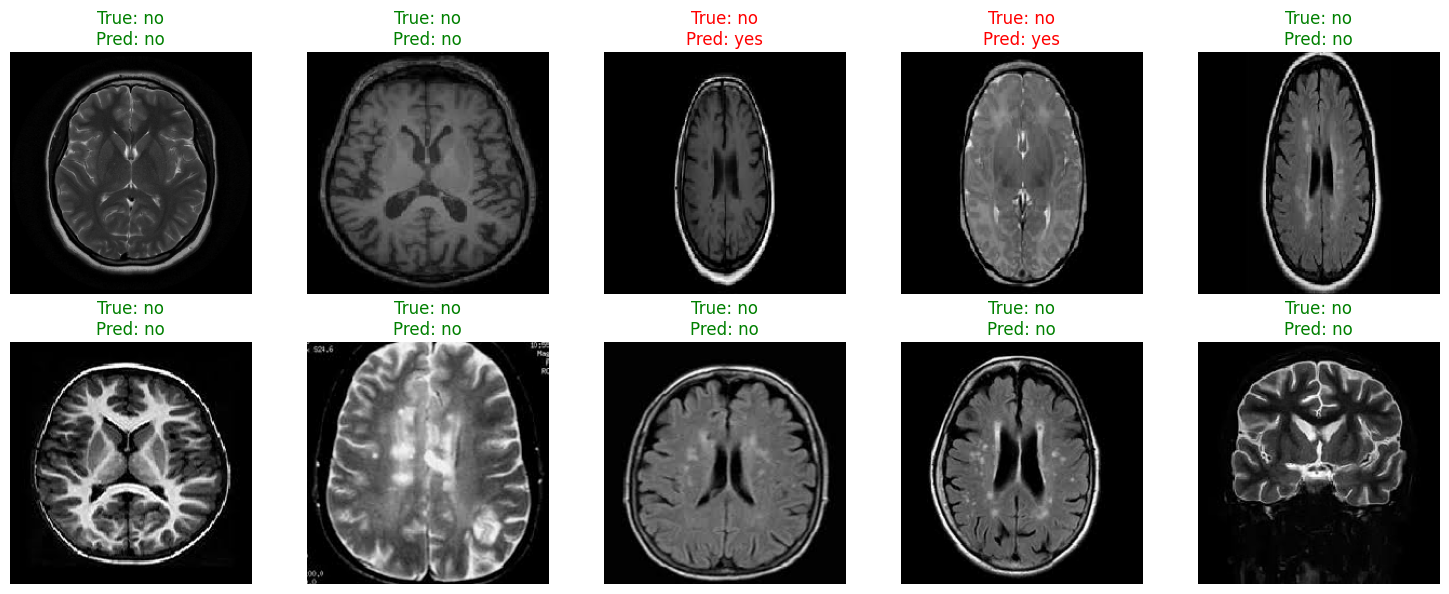

In [1]:
import os
import zipfile
import shutil
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import class_weight
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Step 1: Unzip Dataset
zip_path = "/content/Brain Tumor.zip"
extract_path = "/content/brain_tumor_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

nested_folder = os.path.join(extract_path, "brain_tumor_dataset")
if os.path.exists(nested_folder):
    shutil.rmtree(nested_folder)

print("Dataset folders:", os.listdir(extract_path))


# Step 2: Data Generators with Augmentation
IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = train_datagen.flow_from_directory(
    extract_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)
val_gen = val_datagen.flow_from_directory(
    extract_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)


# Step 3: Class Weights
cw = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(cw))


# Step 4: Build Model
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])


# Step 5: Callbacks
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-6)


# Step 6: Train Model silently
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=0  # silent training output
)


# Step 7: Evaluate and print only classification report
val_gen.reset()
pred_probs = model.predict(val_gen)
pred_labels = (pred_probs > 0.5).astype(int).flatten()
true_labels = val_gen.classes

class_names = list(val_gen.class_indices.keys())
print(classification_report(true_labels, pred_labels, target_names=class_names))


# ======= Visualize some predictions with labels =======
def plot_predictions(images, true_labels, pred_labels, class_names, n=10):
    plt.figure(figsize=(15,6))
    for i in range(n):
        plt.subplot(2,5,i+1)
        plt.imshow(images[i])
        title_color = 'green' if true_labels[i] == pred_labels[i] else 'red'
        plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}", color=title_color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Get one batch of validation images and labels
val_gen.reset()
imgs, labels = next(val_gen)

# Predict on this batch
preds_prob_batch = model.predict(imgs)
preds_batch = (preds_prob_batch > 0.5).astype(int).reshape(-1)

plot_predictions(imgs, labels.astype(int), preds_batch, class_names, n=10)


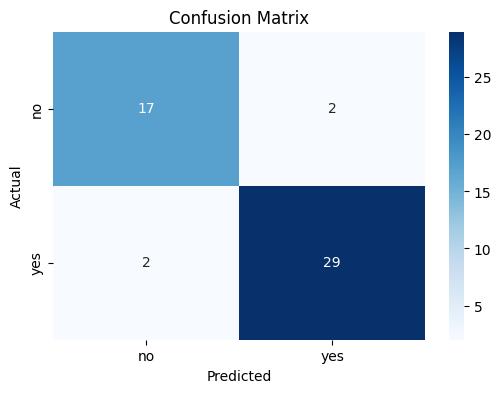

In [2]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()